# Predictions

In [1]:
import sys

sys.path.append('..')

In [2]:
import polars as pl
from typing import Dict, Any
from src.dataset import DatasetGenerator
from src.model import RandomForestPredictor, LgbmPredictor, Predictor
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_absolute_error,
    explained_variance_score,
    root_mean_squared_error
)

In [3]:
generator = DatasetGenerator('../data/df.csv')

### RandomForest model

In [4]:
(X_train, y_train), (X_test, y_test) = generator.split_train_test()
predictor = RandomForestPredictor('../checkpoints/rf.pkl')

Firstly, let's train RandomForestPredictor

In [5]:
predictor.train(X_train, y_train, force=True)

[I 2024-05-31 18:10:41,760] A new study created in memory with name: no-name-cb7d43bd-0df5-4301-9dc6-218d8e0bc5dc


Model already trained. Starting retraining...


[I 2024-05-31 18:13:39,162] Trial 2 finished with value: -5.22086988635236 and parameters: {'n_estimators': 763, 'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 11, 'bootstrap': False}. Best is trial 2 with value: -5.22086988635236.
[I 2024-05-31 18:15:08,520] Trial 3 finished with value: -4.533717956201964 and parameters: {'n_estimators': 697, 'max_depth': 5, 'min_samples_split': 11, 'min_samples_leaf': 11, 'bootstrap': False}. Best is trial 3 with value: -4.533717956201964.
[I 2024-05-31 18:19:59,357] Trial 7 finished with value: -4.396972014389288 and parameters: {'n_estimators': 1391, 'max_depth': 4, 'min_samples_split': 11, 'min_samples_leaf': 7, 'bootstrap': True}. Best is trial 7 with value: -4.396972014389288.
[I 2024-05-31 18:27:30,460] Trial 1 finished with value: -3.921661255874781 and parameters: {'n_estimators': 565, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 9, 'bootstrap': True}. Best is trial 1 with value: -3.921661255874781.
[I 2024-05-31 

In [6]:
predictor.save('../checkpoints/rf.pkl')

Overriding /Users/lezhocheck/Documents/projects/sales-prediction/checkpoints/rf.pkl


In [7]:
# draft evaluation with cross-validation to see baseline metrics
predictor.eval(X_train, y_train, apply_cv=True)

{'test_neg_root_mean_squared_error': -37.85311533720305,
 'test_neg_mean_absolute_error': -3.85742598771933,
 'test_explained_variance': 0.9576448900922685}

In [8]:
# also draft evaluation on the test set with known historical sales_quantity
predictor.eval(X_test, y_test, apply_cv=False)

{'test_neg_root_mean_squared_error': -45.233471572618406,
 'test_neg_mean_absolute_error': -4.146158395764014,
 'test_explained_variance': 0.9455420926544343}

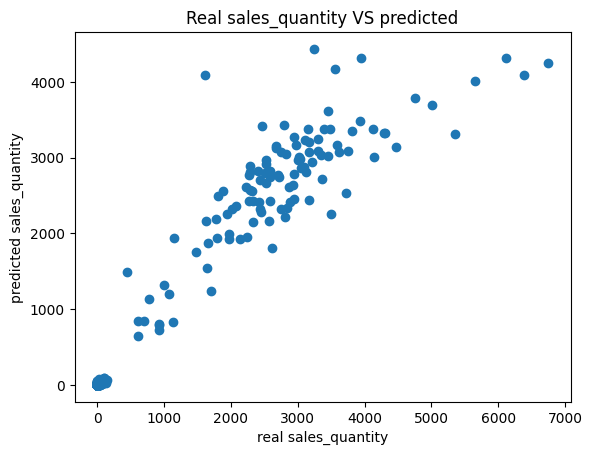

In [9]:
# let's visualize predictions VS real sales_quantity
predicted = predictor.predict(X_test)
plt.title('Real sales_quantity VS predicted')
plt.scatter(y_test, predicted)
plt.xlabel('real sales_quantity')
plt.ylabel('predicted sales_quantity')
plt.show()

But the problem is that in **df_future** we do not have historical quantity sales. So it is needed to come up with some other clever idea to calculate lags and sma.

- We need somehow to calculate lags and other rolling features for the df-future dataset. 
- The idea is to simulate historical data of sales_quantity with realtime stream and process those values one by one. Instead of real quantity I will use model prediction as sales_quantity for data points with unknown sales_quantity (it is not the best solution, but for the purpose of this research would be ok).
- This current solution implementation is too slow and needs to be improved.
- In production environment historical data is always available, so the calculation of lags and other similar features would be easy and fast.

#### Let's simulate df_future data with our test_set, fill those values as mentioned above and evaluate resulting metrics

In [10]:
# helper class with realtime aggregation building logic and predictor evaluation
class Evaluator:
    def __init__(self, predictor: Predictor) -> None:
        self._predictor = predictor
        self._testing_set = X_test.select(
            'category_id', 'sku_id', 'sales_price', 'year', 'month', 'day', 'weekday', 'is_ukrainian_holiday'
        ).with_columns(
            pl.date(pl.col('year'), pl.col('month'), pl.col('day'))
        )
        self._real_test_data = X_test.with_columns(
            y_test, 
            pl.date(pl.col('year'), pl.col('month'), pl.col('day'))
        ).select(*self._testing_set.columns, 'sales_quantity')
        self._historical_data_pool = X_train.with_columns(
            y_train,
            pl.date(pl.col('year'), pl.col('month'), pl.col('day'))
        )  

    def predict_mock_df(self) -> pl.DataFrame:
        result = self._augment_predict(self._testing_set)
        return result.join(
            self._real_test_data, 
            on=[col for col in result.columns if col != 'sales_quantity']
        )

    def predict_future_df(self, data: pl.DataFrame) -> pl.DataFrame:
        data = data.with_columns(
            pl.date(pl.col('year'), pl.col('month'), pl.col('day'))
        ).select(self._testing_set.columns)
        return self._augment_predict(data)

    def _augment_predict(self, data: pl.DataFrame) -> pl.DataFrame:
        result = pl.DataFrame()
        for _, group in tqdm(data.group_by(['sku_id'])):
            # iterate groups one by one
            for sample in group.sort(by='date').iter_rows():
                sample = dict(zip(group.columns, sample))
                sample = self._augment_raw_sample(sample)
                quantity = self._predictor.predict_single_sample(sample)
                sample['sales_quantity'] = quantity
                row = pl.DataFrame([sample]).with_columns(
                    pl.col('cluster_id').cast(pl.Int32),
                    pl.col('year').cast(pl.Int32),
                    pl.col('month').cast(pl.Int8),
                    pl.col('day').cast(pl.Int8),
                    pl.col('weekday').cast(pl.Int8)
                ).select(self._historical_data_pool.columns)
                self._historical_data_pool = self._historical_data_pool.vstack(row)
                result = result.vstack(row)
        return result.select(*self._testing_set.columns, 'sales_quantity')
 
    def _augment_raw_sample(self, sample: Dict[str, Any]) -> Dict[str, Any]:
        closest_rows = self._historical_data_pool.group_by(['sku_id', 'date']).agg(
            pl.col('sales_price').mean(),
            pl.col('sales_quantity').sum()
        ).filter(
            pl.col('sku_id') == sample['sku_id'],
            pl.col('date') <= sample['date']
        ).sort('date', descending=True).head(DatasetGenerator.NUM_LAGS).select(
            'sales_price', 'sales_quantity'
        )
        for idx in range(1, 4):
            sample[f'lag_{idx}_sales_price'] = None
            sample[f'lag_{idx}_sales_quantity'] = None

        for idx, (sales_price, sales_quantity) in enumerate(closest_rows.iter_rows()):
            sample[f'lag_{idx+1}_sales_price'] = sales_price
            sample[f'lag_{idx+1}_sales_quantity'] = sales_quantity
        
        # same for category for sma5 calculation
        closest_rows = self._historical_data_pool.group_by(['category_id', 'date']).agg(
            pl.col('sales_price').mean(),
            pl.col('sales_quantity').sum()
        ).filter(
            pl.col('category_id') == sample['category_id'],
            pl.col('date') <= sample['date']
        ).sort('date', descending=True).head(DatasetGenerator.WINDOW_SIZE).select(
            'sales_price', 'sales_quantity'
        )
        sample['sma_5_sales_price'] = closest_rows['sales_price'].mean()
        sample['sma_5_sales_quantity'] = closest_rows['sales_quantity'].mean()
        if None in sample.values():
            sample['cluster_id'] = None
        else:
            features = pl.DataFrame(sample).select(generator.cluster_generator.feature_names_in_)
            cluster = generator.cluster_generator.predict(features)
            sample['cluster_id'] = cluster
        return sample

In [11]:
evaluator = Evaluator(predictor)
rf_mock_predicted = evaluator.predict_mock_df()

867it [42:55,  2.97s/it]


In [12]:
mae = mean_absolute_error(rf_mock_predicted['sales_quantity_right'], rf_mock_predicted['sales_quantity'])
rmse = root_mean_squared_error(rf_mock_predicted['sales_quantity_right'], rf_mock_predicted['sales_quantity'])
evs = explained_variance_score(rf_mock_predicted['sales_quantity_right'], rf_mock_predicted['sales_quantity'])
metrics = {
    'test_neg_root_mean_squared_error': -rmse,
    'test_neg_mean_absolute_error': -mae,
    'test_explained_variance': evs
}
metrics

{'test_neg_root_mean_squared_error': -71.97492602673157,
 'test_neg_mean_absolute_error': -5.641214302501109,
 'test_explained_variance': 0.8623475761973248}

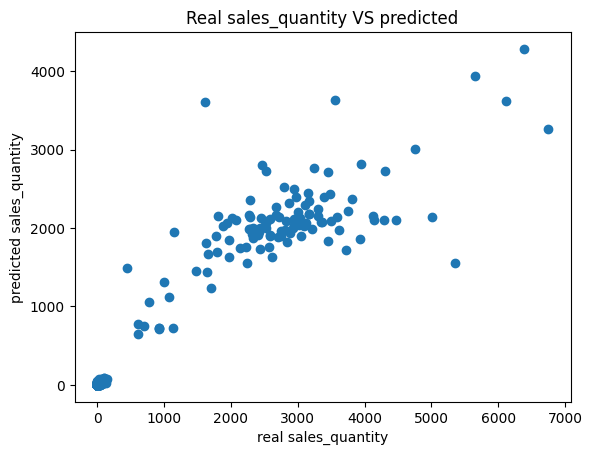

In [13]:
plt.title('Real sales_quantity VS predicted')
plt.scatter(rf_mock_predicted['sales_quantity_right'], rf_mock_predicted['sales_quantity'])
plt.xlabel('real sales_quantity')
plt.ylabel('predicted sales_quantity')
plt.show()

### Lgbm model

In [14]:
lgbm_pred = LgbmPredictor('../checkpoints/lgbm.pkl')
lgbm_pred.train(X_train, y_train, force=True)

[I 2024-05-31 19:29:14,415] A new study created in memory with name: no-name-799062a4-f026-4582-bb95-bbba14f94b64


Model already trained. Starting retraining...


[I 2024-05-31 19:29:22,624] Trial 1 finished with value: -21.92590741793026 and parameters: {'n_estimators': 1193, 'learning_rate': 0.0011502800841299357, 'num_leaves': 231, 'max_depth': 1, 'min_data_in_leaf': 74, 'lambda_l1': 4.150471898155031e-08, 'lambda_l2': 1.101019023690334, 'feature_fraction': 0.4207015265299369, 'bagging_fraction': 0.7071689293518855, 'bagging_freq': 5, 'min_gain_to_split': 0.21583616854587795, 'max_bin': 11, 'min_sum_hessian_in_leaf': 6.473078292209896}. Best is trial 1 with value: -21.92590741793026.
[I 2024-05-31 19:29:42,334] Trial 0 finished with value: -4.205933052289642 and parameters: {'n_estimators': 1064, 'learning_rate': 0.006920506707657999, 'num_leaves': 12, 'max_depth': 21, 'min_data_in_leaf': 65, 'lambda_l1': 1.2040236633459225e-07, 'lambda_l2': 1.0425419848919662e-06, 'feature_fraction': 0.42072234577335677, 'bagging_fraction': 0.6424920034063775, 'bagging_freq': 1, 'min_gain_to_split': 0.7330395890578422, 'max_bin': 165, 'min_sum_hessian_in_lea

In [15]:
lgbm_pred.save('../checkpoints/lgbm.pkl')

Overriding /Users/lezhocheck/Documents/projects/sales-prediction/checkpoints/lgbm.pkl


In [16]:
lgbm_evaluator = Evaluator(lgbm_pred)
lgbm_mock_predicted = lgbm_evaluator.predict_mock_df()

867it [27:39,  1.91s/it]


In [17]:
mae = mean_absolute_error(lgbm_mock_predicted['sales_quantity_right'], lgbm_mock_predicted['sales_quantity'])
rmse = root_mean_squared_error(lgbm_mock_predicted['sales_quantity_right'], lgbm_mock_predicted['sales_quantity'])
evs = explained_variance_score(lgbm_mock_predicted['sales_quantity_right'], lgbm_mock_predicted['sales_quantity'])
metrics = {
    'test_neg_root_mean_squared_error': -rmse,
    'test_neg_mean_absolute_error': -mae,
    'test_explained_variance': evs
}
metrics

{'test_neg_root_mean_squared_error': -66.06168223192182,
 'test_neg_mean_absolute_error': -5.428686730742302,
 'test_explained_variance': 0.8839897088556448}

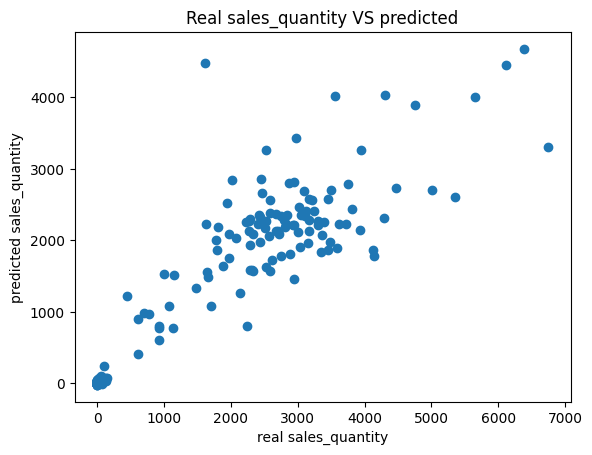

In [18]:
plt.title('Real sales_quantity VS predicted')
plt.scatter(lgbm_mock_predicted['sales_quantity_right'], lgbm_mock_predicted['sales_quantity'])
plt.xlabel('real sales_quantity')
plt.ylabel('predicted sales_quantity')
plt.show()

### DF_FUTURE prediction

Let's now predict sales_quantity in the **df_future.csv** with best model - LGBM

In [19]:
df_future_gen = DatasetGenerator(
    '../data/df_future.csv', 
    generate_lags=False,
    remove_nulls=False,
    generate_clusters=False,
    generate_sma=False
)
X_df_future, _ = df_future_gen.get_full_train_data()
X_df_future

category_id,sku_id,sales_price,year,month,day,weekday,is_ukrainian_holiday
i64,i64,f64,i32,i8,i8,i8,bool
7,532442,375.7,2020,11,2,1,false
7,350059,830.7,2020,11,2,1,false
7,414183,336.7,2020,11,5,4,false
7,522682,531.7,2020,11,2,1,false
7,734215,648.7,2020,11,11,3,false
…,…,…,…,…,…,…,…
17,471831,71.422,2020,11,4,3,false
7,549363,465.452,2020,11,5,4,false
7,350076,167.7,2020,11,6,5,false


In [23]:
lgbm_evaluator = Evaluator(lgbm_pred)
results = lgbm_evaluator.predict_future_df(X_df_future).select(
    'date', 'category_id', 'sku_id' , 'sales_price', 'sales_quantity'
)
results

812it [06:11,  2.18it/s]


date,category_id,sku_id,sales_price,sales_quantity
date,i64,i64,f64,f64
2020-11-01,7,50227,1038.7,1.418004
2020-11-02,7,50227,1038.7,1.376099
2020-11-03,7,50227,1038.7,1.358171
2020-11-04,7,50227,1038.7,1.354873
2020-11-05,7,50227,1038.7,1.359916
…,…,…,…,…
2020-11-10,7,739150,309.582,2.000112
2020-11-11,7,739150,309.582,2.035673
2020-11-12,7,739150,309.582,2.06793


In [24]:
results.write_csv('../data/df_future_predictions.csv')